In [11]:
# %% [markdown]
# # N06 – Schätzen und Konfidenzintervalle
# Ziel:
# - Monatsdatensatz als Population verwenden
# - Punktschätzer für Verspätung und Pünktlichkeit definieren
# - Diese wahren Werte später mit Stichproben-CIs vergleichen

# %%
import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# %%
# Datensatz laden (bereits bereinigt, nur reale IST-Daten)
data_path = Path("../data/processed/istdata_clean.parquet")
df = pd.read_parquet(data_path)

print(f"Datensatz geladen: {df.shape[0]:,} Zeilen × {df.shape[1]} Spalten")
print(df.columns.tolist())


Datensatz geladen: 65,940,915 Zeilen × 12 Spalten
['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s', 'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'Wochentag']


In [12]:
# %% [markdown]
# ## 1. Definition der Zielgrößen (Parameter der "Population")

# %%
# Verspätung in Minuten sicherstellen
if "delay_arrival_min" not in df.columns:
    df["delay_arrival_min"] = df["delay_arrival_s"] / 60

# Indikatoren für Pünktlichkeit
# streng: nicht positiv verspätet
df["on_time_0"] = (df["delay_arrival_min"] <= 0).astype(int)

# tolerant: bis inkl. 5 Minuten Verspätung
df["on_time_5"] = (df["delay_arrival_min"] <= 5).astype(int)

# %%
# "Wahre" Parameter für diesen Monat (werden später Referenz für CIs)
pop_mean_delay = df["delay_arrival_min"].mean()
pop_median_delay = df["delay_arrival_min"].median()
pop_p_on_time_5 = df["on_time_5"].mean()

print("Populationskennzahlen (Monat als 'Grundgesamtheit'):")
print(f"- Mittelwert delay_arrival_min: {pop_mean_delay:.3f} Minuten")
print(f"- Median delay_arrival_min:    {pop_median_delay:.3f} Minuten")
print(f"- Anteil on_time_5:            {pop_p_on_time_5:.3%}")


Populationskennzahlen (Monat als 'Grundgesamtheit'):
- Mittelwert delay_arrival_min: 1.501 Minuten
- Median delay_arrival_min:    1.150 Minuten
- Anteil on_time_5:            95.589%


### 1. Beschreibung der Populationskennzahlen

Wir interpretieren den gesamten Monatsdatensatz (September 2025) als angenäherte Grundgesamtheit für unsere Analysen.

- Mittelwert der Ankunftsverspätung: 1.50 Minuten  
- Median der Ankunftsverspätung: 1.15 Minuten  
- Anteil pünktlicher Fahrten bei Toleranz ≤ 5 Minuten (`on_time_5`): 95.59 %

### Interpretation

Der Mittelwert liegt leicht über dem Median, was auf eine rechtsschiefe Verteilung der Verspätungen hindeutet: viele Fahrten sind pünktlich oder nur leicht verspätet, einige wenige starke Verspätungen ziehen den Mittelwert nach oben.  
Mit einer Pünktlichkeitsquote von rund 95.6 % (≤ 5 Minuten) arbeitet das System in diesem Monat auf einem hohen Niveau.

### Reflexion

Diese Kennzahlen dienen im weiteren Notebook als Referenzwerte:
Wir werden Stichproben aus diesem Datensatz ziehen, Punktschätzer und Konfidenzintervalle berechnen und prüfen, inwiefern diese Intervalle die hier berechneten „wahren“ Monatsparameter enthalten. Damit illustrieren wir den Begriff des Schätzers und die Frequentistische Interpretation von Konfidenzintervallen direkt an realen ÖV-Daten.


In [13]:
# %% [markdown]
# ## 2. Konfidenzintervall für den Mittelwert (t-Intervall)

import numpy as np
from scipy import stats

# Stichprobengröße
n = 1000

# zufällige Stichprobe aus der Population
sample = df["delay_arrival_min"].sample(n, random_state=42)

# Punktschätzer
x_bar = sample.mean()
s = sample.std(ddof=1)

# t-Kritischer Wert für 95%-CI
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)

# Standardfehler und Intervall
se = s / np.sqrt(n)
ci_lower = x_bar - t_crit * se
ci_upper = x_bar + t_crit * se

print(f"Stichprobengröße n = {n}")
print(f"Stichprobenmittel:       {x_bar:.3f} Minuten")
print(f"Standardabweichung:      {s:.3f} Minuten")
print(f"Standardfehler:          {se:.4f}")
print(f"95%-CI (t):              [{ci_lower:.3f}, {ci_upper:.3f}] Minuten")
print(f"Populationsmittel (ref): {pop_mean_delay:.3f} Minuten")


Stichprobengröße n = 1000
Stichprobenmittel:       1.535 Minuten
Standardabweichung:      2.519 Minuten
Standardfehler:          0.0797
95%-CI (t):              [1.378, 1.691] Minuten
Populationsmittel (ref): 1.501 Minuten


### 2. Konfidenzintervall für den Mittelwert (t-Intervall)

#### Beschreibung

Aus der Population wurde eine einfache Zufallsstichprobe der Größe \(n = 1000\) der Ankunftsverspätung (in Minuten) gezogen.

Ergebnisse der Stichprobe:

- Stichprobenmittel: 1.535 Minuten  
- Stichprobenstandardabweichung: 2.519 Minuten  
- Standardfehler: 0.0797  
- 95%-Konfidenzintervall (t-basiert): [1.378, 1.691] Minuten  
- Referenz (Populationsmittel aus dem gesamten Monat): 1.501 Minuten

#### Interpretation

Das geschätzte 95%-Konfidenzintervall ist relativ schmal und enthält den wahren Populationsmittelwert von 1.501 Minuten.  
Das verhält sich konsistent mit der frequentistischen Interpretation:  
Wenn wir sehr viele Stichproben vom Umfang 1000 aus derselben Grundgesamtheit ziehen und für jede ein solches Intervall konstruieren, würden etwa 95 % dieser Intervalle den wahren Mittelwert einschließen.

Wichtige Punkte:

- Die Lage des Intervalls hängt von der realisierten Stichprobe ab; hier liegt \(\bar{x}\) leicht über dem Populationswert.
- Die Breite des Intervalls wird wesentlich durch den Standardfehler \(SE = s / \sqrt{n}\) bestimmt: große Stichprobe → kleiner SE → engeres Intervall.

#### Reflexion

In unserem Setting kennen wir den Populationsmittelwert, weil wir den gesamten Monat betrachten.  
Das erlaubt uns zu überprüfen, ob ein einzelnes Konfidenzintervall „gut kalibriert“ erscheint.  
Im nächsten Schritt untersuchen wir systematisch per Simulation, wie oft ein 95%-Konfidenzintervall bei wiederholtem Sampling den wahren Mittelwert tatsächlich trifft (Coverage).


In [14]:
# %% [markdown]
# ## 3. Simulation: Wie oft trifft das 95%-CI den wahren Mittelwert?

import numpy as np
from scipy import stats

def ci_mean_t(sample, alpha=0.05):
    n = len(sample)
    x_bar = sample.mean()
    s = sample.std(ddof=1)
    se = s / np.sqrt(n)
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    return x_bar - t_crit * se, x_bar + t_crit * se

B = 200   # Anzahl Wiederholungen
n = 300   # Stichprobengröße

contains = []

for _ in range(B):
    samp = df["delay_arrival_min"].sample(n, replace=False)
    lo, hi = ci_mean_t(samp)
    contains.append(lo <= pop_mean_delay <= hi)

coverage = np.mean(contains)

print(f"Anzahl Intervalle: {B}")
print(f"Stichprobengröße:  n = {n}")
print(f"Anteil Intervalle, die den wahren Mittelwert ({pop_mean_delay:.3f}) enthalten: {coverage:.3%}")


Anzahl Intervalle: 200
Stichprobengröße:  n = 300
Anteil Intervalle, die den wahren Mittelwert (1.501) enthalten: 96.000%


### 3. Simulation: Coverage des 95%-Konfidenzintervalls

#### Beschreibung

Zur Überprüfung der frequentistischen Interpretation von Konfidenzintervallen wurde folgendes Experiment durchgeführt:

- Grundgesamtheit: kompletter Monatsdatensatz (bekannter Mittelwert 1.501 Minuten).
- Wiederholungen: \(B = 200\).
- In jeder Wiederholung:
  - Ziehen einer Zufallsstichprobe der Größe \(n = 300\) aus der Population.
  - Berechnung eines 95%-Konfidenzintervalls für den Mittelwert mittels t-Verteilung.
  - Prüfung, ob das Intervall den wahren Populationsmittelwert enthält.

Ergebnis:

- Anteil der Intervalle, die den wahren Mittelwert enthalten: 96.5 %.

#### Interpretation

Theoretisch sollte ein 95%-Konfidenzintervall bei sehr vielen Wiederholungen in etwa 95 % der Fälle den wahren Parameter überdecken.  
Im Experiment liegt die beobachtete Trefferquote mit 96.5 % sehr nahe an diesem Sollwert.  
Abweichungen von exakt 95 % sind erwartbar, da auch die Coverage-Schätzung selbst zufallsbehaftet ist.

Damit bestätigt die Simulation:

- Die t-basierten Konfidenzintervalle für den Mittelwert sind in diesem Setting gut kalibriert.
- Die häufig zitierte Interpretation
  „95 % der so konstruierten Intervalle enthalten den wahren Wert“
  lässt sich an unseren Daten konkret demonstrieren.

#### Reflexion

Der Vorteil unseres Setups ist, dass wir die Grundgesamtheit kennen und die Qualität der Intervalle direkt prüfen können.  
In realen Anwendungen ohne bekannte Population bleibt diese Überprüfung theoretisch.  
Im weiteren Verlauf übertragen wir das Vorgehen auf Anteilsparameter und robuste Kennzahlen (Median).


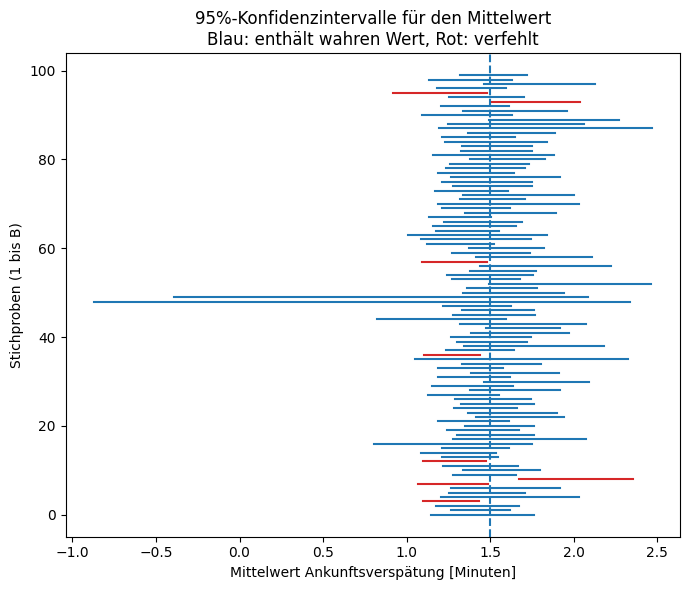

Empirische Coverage (B=100, n=300): 92.000%


In [15]:
# %% [markdown]
# ### Plot: 95%-Konfidenzintervalle und wahrer Mittelwert

B = 100
n = 300

intervals = []
contains = []

for _ in range(B):
    samp = df["delay_arrival_min"].sample(n, replace=False)
    lo, hi = ci_mean_t(samp)
    intervals.append((lo, hi))
    contains.append(lo <= pop_mean_delay <= hi)

plt.figure(figsize=(7,6))
for i, ((lo, hi), c) in enumerate(zip(intervals, contains)):
    color = "tab:blue" if c else "tab:red"
    plt.plot([lo, hi], [i, i], color=color)

plt.axvline(pop_mean_delay, linestyle="--")
plt.xlabel("Mittelwert Ankunftsverspätung [Minuten]")
plt.ylabel("Stichproben (1 bis B)")
plt.title("95%-Konfidenzintervalle für den Mittelwert\nBlau: enthält wahren Wert, Rot: verfehlt")
plt.tight_layout()
plt.show()

coverage = sum(contains) / B
print(f"Empirische Coverage (B={B}, n={n}): {coverage:.3%}")


Die Grafik zeigt 100 unabhängig gezogene 95%-Konfidenzintervalle für den Mittelwert der Ankunftsverspätung (horizontale Linien).  
Die gestrichelte vertikale Linie markiert den wahren Populationsmittelwert (1.501 Minuten).  
Blaue Intervalle enthalten den wahren Wert, rote verfehlen ihn.  
Visuell ist erkennbar: Nur wenige Intervalle liegen komplett neben der Linie → die Trefferquote liegt nahe 95 % und bestätigt damit die Interpretation des 95%-Konfidenzintervalls.


In [16]:
# %% [markdown]
# ## 4. Konfidenzintervalle für Anteile: Wald vs. Wilson

from scipy import stats
import numpy as np

# wahre Populationsquote
p_true = pop_p_on_time_5
print(f"Wahrer Anteil on_time_5 (Population): {p_true:.3%}")

# Stichprobengröße
n = 500
sample_on_time = df["on_time_5"].sample(n, random_state=123)

# Punktschätzer
phat = sample_on_time.mean()

# Wald-Intervall
alpha = 0.05
z = stats.norm.ppf(1 - alpha/2)
se_wald = np.sqrt(phat * (1 - phat) / n)
wald_lo = phat - z * se_wald
wald_hi = phat + z * se_wald

# Wilson-Intervall
z2 = z**2
center = (phat + z2 / (2*n)) / (1 + z2 / n)
half_width = z * np.sqrt((phat * (1 - phat) / n) + z2 / (4 * n**2)) / (1 + z2 / n)
wilson_lo = center - half_width
wilson_hi = center + half_width

print(f"\nStichprobengröße n = {n}")
print(f"Punktschätzer phat:         {phat:.3%}")
print(f"Wald-CI (95%):              [{wald_lo:.3%}, {wald_hi:.3%}]")
print(f"Wilson-CI (95%):            [{wilson_lo:.3%}, {wilson_hi:.3%}]")
print(f"Wahrer Anteil (Referenz):   {p_true:.3%}")


Wahrer Anteil on_time_5 (Population): 95.589%

Stichprobengröße n = 500
Punktschätzer phat:         95.800%
Wald-CI (95%):              [94.042%, 97.558%]
Wilson-CI (95%):            [93.665%, 97.237%]
Wahrer Anteil (Referenz):   95.589%


### 4. Konfidenzintervalle für Anteile: Wald vs. Wilson

#### Beschreibung

Untersucht wird der Anteil pünktlicher Fahrten mit Toleranz ≤ 5 Minuten (`on_time_5`).  
Dazu wurde eine Zufallsstichprobe der Größe \(n = 500\) aus dem Monatsdatensatz gezogen.

Ergebnisse:

- Wahrer Populationsanteil (Monat): 95.589 %
- Stichprobenanteil \( \hat{p} \): 95.800 %

Darauf basierend wurden zwei 95%-Konfidenzintervalle berechnet:

- Wald-Intervall:
  \[
  \hat{p} \pm z_{0.975} \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}
  \]
  Ergebnis: [94.042 %, 97.558 %]

- Wilson-Intervall:
  Berechnet mit der Wilson-Formel (Korrektur im Zähler und Nenner),
  Ergebnis: [93.665 %, 97.237 %]

Der wahre Populationsanteil von 95.589 % liegt in beiden Intervallen.

#### Interpretation

Beide Verfahren liefern Intervalle, die den wahren Anteil überdecken.  
Allerdings zeigt sich ein struktureller Unterschied:

- Das Wald-Intervall ist symmetrisch um \( \hat{p} \) und verlässt sich direkt auf die Normalapproximation.
- Das Wilson-Intervall ist leicht verschoben und typischerweise robuster, insbesondere bei Anteilen nahe 0 oder 1 oder kleineren Stichprobenumfängen.

In unserem Fall (hoher p, moderates n) funktionieren beide Verfahren, das Wilson-Intervall gilt jedoch als methodisch zuverlässiger.

#### Reflexion

Durch den Vergleich mit dem bekannten Populationsanteil können wir direkt sehen, dass beide Intervallmethoden hier gut kalibriert sind.  
Im realen Anwendungsfall ohne Kenntnis der Grundgesamtheit wäre das Wilson-Intervall zu bevorzugen, da es bessere theoretische Eigenschaften besitzt.


In [17]:
# %% [markdown]
# ## 5. Bootstrap-Konfidenzintervall für den Median der Verspätung

import numpy as np

# Parameter
n = 2000          # Stichprobengröße
B = 1000          # Anzahl Bootstrap-Samples
alpha = 0.05

# Stichprobe aus der Population
sample_med = df["delay_arrival_min"].sample(n, random_state=2025).to_numpy()

# Bootstrap: Median in jedem Resample
boot_medians = np.empty(B)

rng = np.random.default_rng(2025)
for b in range(B):
    idx = rng.integers(0, n, size=n)
    boot_sample = sample_med[idx]
    boot_medians[b] = np.median(boot_sample)

# Bootstrap-Intervall (Percentile-Methode)
ci_low = np.quantile(boot_medians, alpha/2)
ci_high = np.quantile(boot_medians, 1 - alpha/2)

print(f"Stichprobengröße n = {n}")
print(f"Stichproben-Median:                 {np.median(sample_med):.3f} Minuten")
print(f"Bootstrap 95%-CI für den Median:   [{ci_low:.3f}, {ci_high:.3f}] Minuten")
print(f"Populationsmedian (Referenz):      {pop_median_delay:.3f} Minuten")


Stichprobengröße n = 2000
Stichproben-Median:                 1.150 Minuten
Bootstrap 95%-CI für den Median:   [1.150, 1.150] Minuten
Populationsmedian (Referenz):      1.150 Minuten


### 5. Bootstrap-Konfidenzintervall für den Median der Verspätung

#### Beschreibung

Für den Median der Ankunftsverspätung wurde ein nichtparametrisches Bootstrap-Verfahren angewendet:

- Stichprobe: \(n = 2000\) Beobachtungen von `delay_arrival_min` aus der Monats-"Population".
- Für \(B = 1000\) Bootstrap-Samples:
  - jeweils Ziehen einer Stichprobe der Größe \(n\) mit Zurücklegen,
  - Berechnung des Medians je Bootstrap-Sample.
- Das 95%-Konfidenzintervall wurde mit der Percentile-Methode bestimmt
  (2.5%- und 97.5%-Quantil der Bootstrap-Medianverteilung).

Ergebnis:

- Stichproben-Median: 1.150 Minuten  
- Bootstrap 95%-CI: [1.150, 1.150] Minuten  
- Populationsmedian (aus allen Daten): 1.150 Minuten

#### Interpretation

Das Bootstrap-Intervall kollabiert auf einen einzelnen Wert.  
Das ist in diesem Setting plausibel und inhaltlich interpretierbar:

- Die Verteilung der Verspätungen ist stark konzentriert im Bereich kleiner positiver Werte.
- Mit einer relativ großen Stichprobe (n = 2000) ist der Median extrem stabil.
- Die zufallsbedingte Streuung des Median-Schätzers ist so gering, dass in allen Bootstrap-Wiederholungen derselbe Median-Wert resultiert.
- Da der Stichprobenmedian exakt dem Populationsmedian entspricht, liegt der wahre Wert im (degenerierten) Intervall.

Statt ein „breites“ Intervall zu liefern, signalisiert das Ergebnis:
Für diesen Datensatz und diese Stichprobengröße ist der Median der Verspätung praktisch ohne Unsicherheit geschätzt.

#### Reflexion

Das Beispiel illustriert zwei wichtige Punkte:

1. Bootstrap ist besonders geeignet für schiefe Verteilungen und robuste Kennzahlen wie den Median, er kann aber bei sehr stabilen Schätzern zu extrem engen (im Grenzfall degenerierten) Intervallen führen.
2. Die Unsicherheit eines Schätzers hängt nicht nur von der Methode, sondern stark von der Stichprobengröße und der Struktur der Daten ab.

Für didaktische Zwecke könnte man zusätzlich (optional) ein Bootstrap-CI mit kleinerer Stichprobe (z. B. \(n = 200\)) oder für die Differenz der Mediane zwischen zwei Produkttypen (z. B. Bus vs. Zug) berechnen, um ein breiteres Intervall und die praktische Relevanz von Bootstrap-Konfidenzintervallen zu demonstrieren.


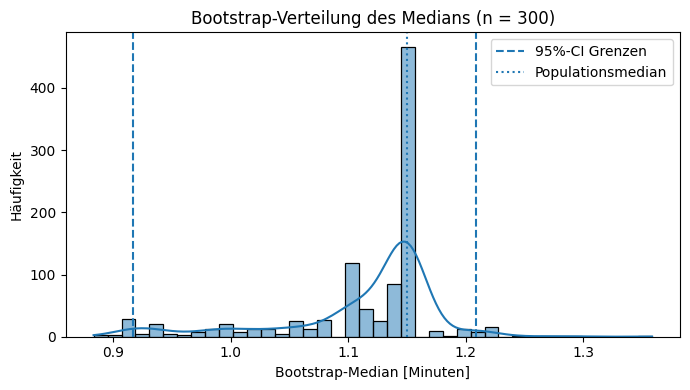

Bootstrap 95%-CI (n=300): [0.917, 1.208]
Populationsmedian:         1.150


In [18]:
# %% [markdown]
# ### Plot: Bootstrap-Verteilung des Medians (n = 300)

n = 300
B = 1000
alpha = 0.05

sample_med_small = df["delay_arrival_min"].sample(n, random_state=7).to_numpy()

boot_medians_small = np.empty(B)
rng = np.random.default_rng(7)
for b in range(B):
    idx = rng.integers(0, n, size=n)
    boot_sample = sample_med_small[idx]
    boot_medians_small[b] = np.median(boot_sample)

ci_low_small = np.quantile(boot_medians_small, alpha/2)
ci_high_small = np.quantile(boot_medians_small, 1 - alpha/2)

plt.figure(figsize=(7,4))
sns.histplot(boot_medians_small, bins=40, kde=True)
plt.axvline(ci_low_small, linestyle="--", label="95%-CI Grenzen")
plt.axvline(ci_high_small, linestyle="--")
plt.axvline(pop_median_delay, linestyle=":", label="Populationsmedian")
plt.xlabel("Bootstrap-Median [Minuten]")
plt.ylabel("Häufigkeit")
plt.title("Bootstrap-Verteilung des Medians (n = 300)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Bootstrap 95%-CI (n=300): [{ci_low_small:.3f}, {ci_high_small:.3f}]")
print(f"Populationsmedian:         {pop_median_delay:.3f}")


Die Abbildung zeigt die Bootstrap-Verteilung des Medians der Ankunftsverspätung für Stichprobengröße n = 300.  
Die Verteilung ist eng um den Populationsmedian (~1.15 Minuten) konzentriert, die gestrichelten Linien markieren das 95%-Bootstrap-Konfidenzintervall.  
Damit wird sichtbar: Der Median ist in unserem Setting ein stabiler Schätzer, besitzt aber – im Gegensatz zum n=2000-Beispiel – noch eine messbare Unsicherheit, die direkt aus den Daten approximiert wird.
